This notebook contains the code to create two types of personalized datasets for training (and validation):

1.- Random: Original data

In [1]:
import sys
import pathlib
root_repo_directory = pathlib.Path().resolve().parent.__str__()
sys.path.append(root_repo_directory)
#from multilingual_chatbot_arena import initialize
import src.constants as c
import src.utils as utils
import pandas as pd
from fire import Fire
from pydantic import BaseModel
from typing import List,Optional,Dict,Union
import pathlib
import numpy as np
import pickle
from dataclasses import dataclass
import re
import requests

import os
import opik
from loguru import logger


import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline, AutoConfig
from transformers.tokenization_utils import PreTrainedTokenizer
from transformers.tokenization_utils_fast import PreTrainedTokenizerFast
from transformers.pipelines.pt_utils import KeyDataset

from sklearn.metrics import accuracy_score,confusion_matrix
from tqdm import tqdm

from collections import defaultdict
import time

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors

import pyarrow as pa
import pyarrow.parquet as pq

No module named 'datasets_creator'


/home/kevinmg96/miniconda3/envs/wsdm-cup/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#colors
black = mcolors.CSS4_COLORS["black"]
lime = mcolors.CSS4_COLORS["lime"]
aqua = mcolors.CSS4_COLORS["aqua"]
magenta = mcolors.CSS4_COLORS["magenta"]
red = mcolors.CSS4_COLORS["red"]
grey = mcolors.CSS4_COLORS["grey"]
orange = mcolors.CSS4_COLORS["orangered"]
gold = mcolors.CSS4_COLORS["gold"]
blue = mcolors.CSS4_COLORS["blue"]
indigo = mcolors.CSS4_COLORS["indigo"]

# Loading OG challenge's dataset

In [3]:
path = root_repo_directory + c.SLASH + 'data/original'
train_df = pd.read_parquet(path + c.SLASH + "train.parquet")


In [7]:
train_df.columns

Index(['id', 'prompt', 'response_a', 'response_b', 'winner', 'model_a',
       'model_b', 'language', 'num_tokens', 'num_tokens_categories'],
      dtype='object')

In [5]:
root_repo_directory

'/home/kevinmg96/Kaggle competitions/WSDM Cup/multilingual-chatbot-arena/datasets_creator'

In [6]:
train_df.shape[0]

48439

In [4]:
series_language = train_df["language"].value_counts(normalize=True)[(train_df["language"].value_counts(normalize=True) > 0.01).values]

df_series_language = pd.DataFrame({
    "languages" : series_language.keys(),
    "percentages" : series_language.values * 100 
})

In [ ]:
fig,ax = plt.subplots(1,1,figsize= (5,5))
sns.barplot(data=df_series_language,x="languages",y="percentages",ax=ax,color=grey)


ax.tick_params(axis='x', labelrotation=90)
ax.set_xlabel("Language",fontsize=10)
ax.set_ylabel("Percentage (%)",fontsize=10)
ax.set_title("Language's Percentage Distribution in Training Set",fontsize=10)

In [ ]:
train_df["language"].value_counts()[(train_df["language"].value_counts() >= 10).values]

In [ ]:
train_df["language"].value_counts()[(train_df["language"].value_counts() <= 10).values]

# Curated - smaller datasets

## V0

Curated dataset v0 - baseline
This dataset consists of 5 (if possible) random records from each language. if not, then the available records
will be sampled.

This baseline will be used to evaluate zero shot inference LLMs to find how well they can generalize to different
languages, I'll load their responses in comet ML, and rank them.

Results will provide a set point on fine tuning the correct (probably) LLMs.

In [5]:
groupby_language = train_df.groupby(["language"])

for name, group in groupby_language:
    print(f"Group: {name}")
    print(group['winner'].values)

Group: ('Abkhazian',)
['model_a']
Group: ('Afar',)
['model_a']
Group: ('Afrikaans',)
['model_a' 'model_a' 'model_a' 'model_a' 'model_b' 'model_a' 'model_a']
Group: ('Akan',)
['model_b']
Group: ('Albanian',)
['model_b' 'model_a' 'model_a']
Group: ('Amharic',)
['model_b' 'model_a' 'model_a' 'model_a' 'model_b' 'model_b']
Group: ('Arabic',)
['model_b' 'model_b' 'model_a' 'model_b' 'model_b' 'model_a' 'model_a'
 'model_a' 'model_b' 'model_a' 'model_b' 'model_b' 'model_a' 'model_b'
 'model_b' 'model_b' 'model_a' 'model_a' 'model_b' 'model_a' 'model_b'
 'model_b' 'model_a' 'model_a' 'model_b' 'model_b' 'model_b' 'model_b'
 'model_a' 'model_a' 'model_b' 'model_b' 'model_b' 'model_a' 'model_b'
 'model_b' 'model_b' 'model_a' 'model_b' 'model_a' 'model_a' 'model_a'
 'model_a' 'model_a' 'model_a' 'model_b' 'model_b' 'model_b' 'model_a'
 'model_a' 'model_b' 'model_b' 'model_b' 'model_a' 'model_b' 'model_b'
 'model_a' 'model_b' 'model_b' 'model_a' 'model_b' 'model_a' 'model_a'
 'model_b' 'model_a' 

In [8]:
def func(x,**kwargs):

    kwargs['generator'].shuffle(x.to_numpy(),axis= 0)

    if x.shape[0] >= kwargs['num_group_records']:
        return x.iloc[:kwargs['num_group_records']]
    return x


num_group_records = 5
generator = np.random.default_rng(seed=142)
kwargs = {"num_group_records" : num_group_records, 'generator' : generator}



curated_df_v0 = groupby_language.apply(func,**kwargs).reset_index(drop=True)

/tmp/ipykernel_125265/2821983180.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  curated_df_v0 = groupby_language.apply(func,**kwargs).reset_index(drop=True)


In [9]:
curated_df_v0.head()

,id,prompt,response_a,response_b,winner,model_a,model_b,language
0,118c074e1e3880f61f1ecc82b392e6ba250b4cd3bb383f...,Макроэкономика,## Макроэкономика: Обзор\n\nМакроэкономика - э...,Макроэкономика — это раздел экономической наук...,model_a,gemini-1.5-pro-001,gpt-4o-2024-05-13,Abkhazian
1,49aa24778c38c727c3665dd418632176e523999397dc50...,devala maharshi,Devala Maharshi is a revered figure in Hinduis...,Devala Maharshi is a revered sage in Hindu myt...,model_a,deepseek-v2.5,qwen-plus-0828,Afar
2,5fcf043fe50553461dcd3998c4b0a0d373d404291598ee...,Wat is de betekenis van het lied aramsamsam ?,"Een interessante vraag!\n\n""Aramsamsam"" (ook w...",Ik kan geen informatie vinden over een lied ge...,model_a,llama-3.1-nemotron-70b-instruct,llama-3.1-405b-instruct-fp8,Afrikaans
3,632f631eceb574551ef09a497f77405cbf146fc2e49666...,Vertel me een goede mop,"Natuurlijk, hier is een klassieke mop voor je:...",Natuurlijk! Here is a classic Dutch joke for y...,model_a,qwen-plus-0828,deepseek-v2.5,Afrikaans
4,c35fbab864975e41640e0e384e56c57ecc0c6bb2e4254c...,wat is de populairste bezienswaardigheid van D...,De populairste bezienswaardigheid van Duitslan...,De populairste bezienswaardigheid van Duitslan...,model_a,gemini-1.5-pro-002,glm-4-plus,Afrikaans


In [79]:
curated_df_v0.shape

(467, 8)

## Save V0 to parquet

In [15]:
root: str = pathlib.Path().resolve().parent.parent.__str__()

In [13]:
root_repo_directory

'/home/kevinmg96/Kaggle competitions/WSDM Cup/multilingual-chatbot-arena/datasets_creator'

In [76]:
train = pd.read_parquet(root + "/validation/validation_data_1.parquet")

In [78]:
type(train)

pandas.core.frame.DataFrame

In [26]:
train.iloc[0]['prompt']

'Below is a prompt with two possible responses (**Response A** and **Response B**). Evaluate them, select the best one and answer in the following format (it is imperative that you respect the specified format, do not add any more text than what I ask for):\n1.- Write \'model_a\' if the **Response A** is better than **Response B**, otherwise write \'model_b\'.\n\n**Prompt**:\nNoix dator Olentzero?\n\n**Response A**:\nOlentzero Euskal Herriko Gabonetako pertsonaia tradizionala da. Jatorriz ikatzgilea zen eta Gabon gauean etxez etxe opariak banatzen zituen umeentzat, Gabonetako Aita bezalako papera betez. Tradizioz Olentzeroren irudia gizon zahar eta gizen bat da, bizarrarekin eta jantzi tradizionalekin. Gaur egun Olentzero Euskal Herriko Gabonetako ospakizunetan presente dago, kalejiretan eta ekitaldietan parte hartuz. Beraz, euskal kulturan oso errotuta dagoen pertsonaia da, umeentzat ilusioa eta magia dakarrena Gabonetako sasoian.\n\n**Response B**:\nOlentzero es una figura tradiciona

In [12]:
import pyarrow as pa
import pyarrow.parquet as pq
table = pa.Table.from_pandas(curated_df_v0)

# Write Arrow Table to Parquet file
filename = "curated_small_v0.parquet"
file = root_repo_directory + c.SLASH + "data/datasets/curated/" + filename
pq.write_table(table, file)

Curated dataset v1 - Random and  uniform
Languages: English, Russian, Chinese, Vietnamese, German, Japanese, Unknown, Korean, Spanish
French, Portuguese, Persian, Italian, Turkish,Czech, Arabic, Polish , Ukrainian , Dutch, Hungarian



100 samples per language

Total samples: 2,000

Curated dataset v2 - Random and not uniform

English, Russian, Chinese, Vietnamese, German, Japanese, Unknown, Korean :  1,000 samples
Spanish, French, Portuguese : 500 samples
Persian, Italian, Turkish : 200 samples
Czech, Arabic, Polish , Ukrainian , Dutch, Hungarian : 100 samples

Total samples: 8 * 1,000 + 3 * 500 + 3 * 200 + 6 * 100 = 10,700 samples

Curated dataset v3 - Random,uniform, large multilanguages
Languages: English, Russian, Chinese, Vietnamese, German, Japanese, Unknown, Korean, Spanish
French, Portuguese, Persian, Italian, Turkish,Czech, Arabic, Polish , Ukrainian , Dutch, Hungarian


100 samples per language (above)

10 samples per language (below)

Indonesian, Slovak, Swedish, Danish, Finnish, Serbian, Bulgarian, Hebrew, Thai, Romanian, Latin,Galician,
Norwegian, Catalan, Greek, Lithuanian, Croatian, Sanskrit, Estonian, Scots, Basque       66


Total samples: 20 * 100 + 21 * 10 = 2,210 samples

Curated dataset v4 - Random,not uniform, large multilanguages
Mix between v2 and v3.

respect sampling for the languages composed in V2 and include the specified samples from v3 to the remainiding 
languages. i,e. up to Hungarian is v2, and from Indonesian and so on is v3

Curated dataset v5 - Random, not uniform and English biased

Same as v2 except that English samples will be 10k

Curated dataset v6 - Random,uniform, large multilanguages

Same as v3 except that English samples will be 1k

Curated dataset v7 - Random, not uniform and English biased

Same as v2 except that English samples will be 2k

## V5

English, Russian, Chinese, Vietnamese, German, Japanese, Unknown, Korean :  1,000 samples
Spanish, French, Portuguese : 500 samples
Persian, Italian, Turkish : 200 samples
Czech, Arabic, Polish , Ukrainian , Dutch, Hungarian : 100 samples

Total samples: 8 * 1,000 + 3 * 500 + 3 * 200 + 6 * 100 = 10,700 samples

In [7]:
def func(x,**kwargs):

    kwargs['generator'].shuffle(x.to_numpy(),axis= 0)

    main_group = ["Russian", "Chinese", "Vietnamese", "German", "Japanese",  "Korean"]
    second_group = ["Spanish", "French", "Portuguese"]
    third_group = ["Czech", "Arabic", "Polish" , "Ukrainian" , "Dutch", "Hungarian"]

    if x.name == "English":
        return x.iloc[:kwargs["english_records"]]
    elif x.name in main_group:
        return x.iloc[:1000]
    elif x.name in second_group:
        return x.iloc[:500]
    elif x.name in third_group:
        return x.iloc[:100]

    return None




In [ ]:
generator_v5 = np.random.default_rng(seed=142)
kwargs = {'generator' : generator_v5,"english_records" : 10000}



curated_df_v5 = groupby_language.apply(func,**kwargs).reset_index(drop=True)

## Save V5 to parquet

In [23]:

table = pa.Table.from_pandas(curated_df_v5)

# Write Arrow Table to Parquet file
filename = "curated_small_v5.parquet"
file = root_repo_directory + c.SLASH + "data/datasets/curated/" + filename
pq.write_table(table, file)

## V7

In [11]:


generator_v7 = np.random.default_rng(seed=142)
kwargs = {'generator' : generator_v7, "english_records" : 2000}



curated_df_v7 = groupby_language.apply(func,**kwargs).reset_index(drop=True)

/tmp/ipykernel_33736/3857405990.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  curated_df_v7 = groupby_language.apply(func,**kwargs).reset_index(drop=True)


## Save V7 to parquet

In [13]:

table = pa.Table.from_pandas(curated_df_v7)

# Write Arrow Table to Parquet file
filename = "curated_small_v7.parquet"
file = root_repo_directory + c.SLASH + "data/datasets/curated/" + filename
pq.write_table(table, file)

## V8

Curated dataset v8 - Random, uniform, filter by token size

First filter: Conserve records whose prompt has less than 3.5k tokens

Second filter: 
Languages: English, Russian, Chinese, Vietnamese, German, Japanese, Unknown, Korean, Spanish
French, Portuguese, Persian, Italian, Turkish,Czech, Arabic, Polish , Ukrainian , Dutch, Hungarian

100 samples per language (if possible)

Third filter:
Ensure that output class (model_a or model_b) is uniformly distributed



In [4]:
SYSTEM_TEMPLATE = 'You are a specialist in evaluating multilingual chat responses, with a focus on comparing and ranking outputs from different LLMs. Your primary goal is to determine which response is more likely to be preferred by humans based on factors such as clarity, relevance, tone, and overall quality.\n'
PROMPT_TEMPLATE = """Below is a prompt with two possible responses (**Response A** and **Response B**). Evaluate them, select the best one and answer in the following format (it is imperative that you respect the specified format, do not add any more text than what I ask for):\n1.- Write 'model_a' if the **Response A** is better than **Response B**, otherwise write 'model_b'.\n\n**Prompt**:\n{prompt}\n\n**Response A**:\n{response_a}\n\n**Response B**:\n{response_b}\n"""

In [5]:
from transformers import AutoModelForCausalLM, AutoTokenizer
model_name = "Qwen/Qwen2.5-7B-Instruct-GPTQ-Int4"
tokenizer = AutoTokenizer.from_pretrained(
model_name,padding_side="left",legacy=False)

In [6]:
def add_prompt_num_tokens(x,**kwargs):
    tokenizer = kwargs["tokenizer"]

    messages = [
                    {"role": "system", "content": SYSTEM_TEMPLATE},
                    {"role" : "user", "content" : PROMPT_TEMPLATE.format(
                    prompt=x.prompt,response_a=x.response_a,response_b = x.response_b)},
                    {"role" : "assistant", "content" : x.winner}
                ]
    return len(tokenizer.apply_chat_template(messages,add_generation_prompt=True,tokenize=True))

kwargs = {
    "tokenizer" :tokenizer
}
train_df["num_tokens"] = train_df.apply(add_prompt_num_tokens,axis=1,**kwargs)

train_df["num_tokens_categories"] = pd.cut(train_df["num_tokens"],10,labels=np.arange(10))

In [9]:
num_tokens_subset =train_df.query('num_tokens_categories == 0')
group_num_tokens_subset =num_tokens_subset.groupby("language")

def func(x,**kwargs):

    kwargs['generator'].shuffle(x.to_numpy(),axis= 0)


    group = ["English","Russian", "Chinese", "Vietnamese", "German", "Japanese",  "Korean",
                  "Spanish", "French", "Portuguese","Persian", "Italian", "Turkish",
                    "Czech", "Arabic", "Polish" , "Ukrainian" , "Dutch", "Hungarian"]


    if x.name in group:
        return x.iloc[:kwargs["num_records"]]

    return None


num_records = 100
generator = np.random.default_rng(seed=142)
kwargs = {"num_records" : num_records, 'generator' : generator}


curated_df_v8 = group_num_tokens_subset.apply(func,**kwargs).reset_index(drop=True)

/tmp/ipykernel_1111/1205359606.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  curated_df_v8 = group_num_tokens_subset.apply(func,**kwargs).reset_index(drop=True)


Let's assess output class distribution 

In [26]:
series_v8_winners = curated_df_v8.groupby(["winner"]).count()["id"]

df_series_v8_winners = pd.DataFrame({
    "winners" : series_v8_winners.index.values,
    "percentages" : (series_v8_winners.values / curated_df_v8.shape[0]) * 100
})

Text(0.5, 1.0, "Model Winner's distribution for dataset v8")

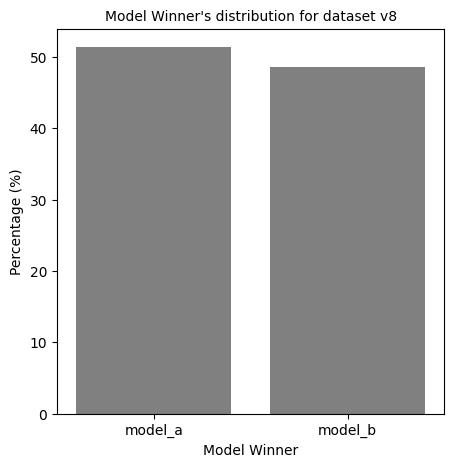

In [27]:
fig,ax = plt.subplots(1,1,figsize= (5,5))
sns.barplot(data=df_series_v8_winners,x="winners",y="percentages",ax=ax,color=grey)


ax.set_xlabel("Model Winner",fontsize=10)
ax.set_ylabel("Percentage (%)",fontsize=10)
ax.set_title("Model Winner's distribution for dataset v8",fontsize=10)

Conclusion: Distribution is almost uniform, continue with the following process.

In [10]:
curated_df_v8

,id,prompt,response_a,response_b,winner,model_a,model_b,language,num_tokens,num_tokens_categories
0,01a0d5a75b02aa185ec1b183dadda41ac9af7dcccb13ae...,اعد صياغة وتحسين هذا prompt \nيرجى إنشاء برنام...,يرجى تطوير دليل تعليمي شامل ومتدرج للمبتدئين ي...,من فضلك، قم بإنشاء برنامج تعليمي شامل ومفصل خط...,model_b,qwen-plus-0828,o1-preview,Arabic,499,0
1,03366d9255419fd5391e926f4bb1124a4b3ee726c1af1c...,اهلا، لما انت عن باقي المنافسين؟,أنا مساعد ذكي اصطناعي مصمم لمساعدة البشر في مه...,أهلاً! هناك عدة أسباب تجعلني متميزًا عن باقي ا...,model_b,claude-3-opus-20240229,yi-lightning,Arabic,681,0
2,03be4e6fd70afe535586561f411421970ffabf0295ff0e...,32: تعتبر المراقبة المستمرة في النظام التعليمي...,في النظام التعليمي المغربي، تعتبر المراقبة الم...,الجواب هو ٢,model_a,glm-4-plus,llama-3.2-3b-instruct,Arabic,345,0
3,03e30e488b735eb8f73e7e1d01015425fafb349de93a8d...,كيف اتعلم الكوبي ريتنك في 15 يوم,"عندما لم_testks mé_""Split ""فيلونثياريونpure to...",تعلم كوبي ريتنك في 15 يومًا هو هدف طموح، لكن ل...,model_b,llama-3.2-1b-instruct,gemma-2-27b-it,Arabic,2956,0
4,0448e77265717324f56e8fbf43a04bb363d48c1fc581fd...,أنت طبيب نفسي، أود أن بإخضاعي لجلسات علاج نفسي...,شكرًا لمصطفى على الشفافية في وصف حالتك. من الم...,واحدة على الأولويات الهامة التي يجب أن Näذكر أ...,model_a,glm-4-plus,llama-3.2-3b-instruct,Arabic,1775,0
...,...,...,...,...,...,...,...,...,...,...
1863,07b1e1cf4944b325fe1bfed39b51c44a6626e01961d011...,"nếu khi hoạt động dưới nắng, da tôi thường đỏ ...","Không, chỉ với triệu chứng da đỏ lên khi hoạt ...","Không, chỉ đơn giản là da đỏ lên khi tiếp xúc ...",model_b,mistral-large-2407,gemini-1.5-flash-8b-exp-0827,Vietnamese,822,0
1864,07d09d3b4628cdecff5361a38e3b45d7a4a800c250e2e2...,PHÂN TÍCH TỜ KHAI HẢI QUAN XUẤT KHẨU B11,Phân tích tờ khai hải quan xuất khẩu B11 là mộ...,Tờ khai hải quan xuất khẩu B11 là một loại tờ ...,model_a,glm-4-plus,llama-3.1-405b-instruct-bf16,Vietnamese,1670,0
1865,07daa626bf958c974eda2a7deb3c85baf0eabf0fe2627f...,Bot giúp kết nối các bạn thành viên để các bạn...,Chào các thành viên NhiLe Team!\n\nTôi là bot ...,Xin chào mọi người!\n\nTôi là Bot của NhiLe Te...,model_a,gemini-1.5-flash-8b-001,reka-flash-20240904,Vietnamese,984,0
1866,0818baf3f947f47b1ae5d38832cf4d966299103e090ada...,Là một doanh nghiệp đang phân phối và bán xoài...,Dưới đây là một số đề xuất cho các bài viết SE...,Dưới đây là danh sách các chủ đề bài viết SEO ...,model_b,claude-3-opus-20240229,claude-3-5-sonnet-20241022,Vietnamese,1422,0


### Save V8 to parquet

In [28]:
table = pa.Table.from_pandas(curated_df_v8)

# Write Arrow Table to Parquet file
filename = "curated_small_v8.parquet"
file = root_repo_directory + c.SLASH + "data/datasets/curated/" + filename
pq.write_table(table, file)